#Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.util import random_noise
import random

#Preparer le GPU

In [2]:
print(torch.cuda.get_device_name(0))
device = torch.device("cuda")

NVIDIA GeForce RTX 3080 Ti


#Preparer le Dataset

On recupère le dataset CIFAR10 et on le divise en deux sous-datasets:
- L'ensemble d'apprentissage, commposé de 50 000 images
- L'ensemble de test, composé de 10 000 images

On va normaliser les images afin de normaliser les valeurs des pixels dans l'intervalle [0,1]. Pour cela nous avons precisé les moyennes et les ecarts types du dataset.

Enfin nous avons utilisé un loader par sous-dataset en precisant la batch size de chacun.



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


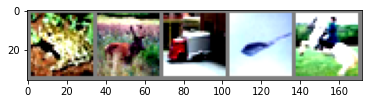

frog      deer      truck     plane     horse


In [3]:
#Functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
num_img = 5
example_loader = torch.utils.data.DataLoader(trainset, batch_size=num_img, shuffle=True, num_workers=2)
dataiter = iter(example_loader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('     '.join(f'{classes[labels[j]]:5s}' for j in range(num_img)))

#Architecture du modèle

Pour notre modèle nous avons opté pour l'achitecture VGG. Nous avons prévu plusieurs configurations (VGG11, VG13, VGG16 et VGG19). 

L'architecture du modèle VGG alterne des couches de convolution et des couches de maxpooling.

In [ ]:
#Different architectures of vgg. Represent all the layers
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


#Model class
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    #For each element in the config selectionned, we create the layer associated 
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1, bias=False),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG16')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())
    print(net)

test()

torch.Size([2, 10])
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=

#Entrainement du modèle

In [ ]:
def training(net, criterion, optimizer, scheduler, n_epoch, attack=None, noise=None):
    net.to(device)
    for epoch in range(n_epoch):

        running_loss = 0.0
        test_loss = 0.0

        ##TRAIN
        for i, data in enumerate(train_loader, 0):
            #Get the inputs; data is a list of [images, labels]
            images, labels = data
            #Put images and labels on GPU
            images = images.to(device)
            labels = labels.to(device)
            
            #Attack the images if precised (Adversarial Training)
            if attack != None:
                images = attack.compute(images, labels)

            #Add noise if precised
            if noise != None:
                images = add_noise(images)
    

            #Zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)
            #Forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #Compute loss
            running_loss += loss.item()*images.size(0)
            
        ''' IT ADD TOO MUCH TIME TO THE TRAINING
        ##TEST
        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = net(images)
                loss = criterion(outputs, labels)
                # print statistics
                test_loss += loss.item()*images.size(0)'''

        scheduler.step()
        print(f'epoch {epoch + 1} -> training_loss: {running_loss/50000:.3f}')#, test_loss: {test_loss/10000:.3f}')
    print('Finished Training')

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [ ]:
%%time
model = VGG("VGG16")
#Put the model on GPU
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

n_epoch = 20

print("Training without attack :")
training(model, criterion, optimizer, scheduler, n_epoch)
save_model(model, "./vgg16.pth")

Training without attack :
epoch 1 -> training_loss: 1.568
epoch 2 -> training_loss: 1.014
epoch 3 -> training_loss: 0.772
epoch 4 -> training_loss: 0.608
epoch 5 -> training_loss: 0.481
epoch 6 -> training_loss: 0.383
epoch 7 -> training_loss: 0.303
epoch 8 -> training_loss: 0.245
epoch 9 -> training_loss: 0.198
epoch 10 -> training_loss: 0.156
epoch 11 -> training_loss: 0.129
epoch 12 -> training_loss: 0.108
epoch 13 -> training_loss: 0.092
epoch 14 -> training_loss: 0.076
epoch 15 -> training_loss: 0.071
epoch 16 -> training_loss: 0.057
epoch 17 -> training_loss: 0.050
epoch 18 -> training_loss: 0.051
epoch 19 -> training_loss: 0.047
epoch 20 -> training_loss: 0.038
Finished Training
Wall time: 8min 26s


#Evaluation du modèle

In [ ]:
def eval_model(model, loader, attack=None, noise=None):    
    total =0
    correct =0

    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if attack != None:
            images = attack.compute(images, labels)
        if noise != None:
            images = add_noise(images)


        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    
    print("Correct :",correct)
    print("Total :", total)
    print(f'Accuracy: {100 * correct // total} %')


In [ ]:
model = VGG("VGG16")
model.load_state_dict(torch.load('./vgg16.pth'))
model = model.to(device)
      
print("Eval on clean images :")
eval_model(model, test_loader)

__________________________
Eval on clean images
8231
10000
Accuracy: 82 %


On voit que les resutlats de notre modèles sont très bon !

Mais que se passerait-il si notre ensemble d'images de test venait à être alteré avec une attaque PGD ? Le modèle va-t-il être robuste ?

In [ ]:
class ProjectedGradientDescent:
    """
    A class used to attack the images

    Methods
    -------
    compute(images, labels)
        Compute all the adversarial images
    """
  
    def __init__(self, model, eps, alpha, num_iter):
        self.model = model
        self.eps = eps
        self.alpha=alpha
        self.num_iter=num_iter

    def compute(self, images, labels):
        criterion = nn.CrossEntropyLoss()
        images = images.to(device)
        labels = labels.to(device)
        for t in range(self.num_iter):
            images.requires_grad = True
            outputs = self.model(images)
            self.model.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            adv_images = images + self.alpha*images.grad.sign()
            eta = torch.clamp(adv_images - images.data, min=-self.eps, max=self.eps)
            images = torch.clamp(images.data + eta, min=0, max=1).detach()
        return images
            

In [ ]:
model = VGG("VGG16")
model.load_state_dict(torch.load('./vgg16.pth'))
model = model.to(device)

attack = ProjectedGradientDescent(model,eps=0.03,alpha=0.007,num_iter=20)
print("Eval on attacked images :")
eval_model(model, test_loader, attack)

print("__________________________")
print("Eval on attacked and noised images :")
eval_model(model, test_loader, attack, noise=True)

Eval on attacked images :
Correct : 0
Total : 10000
Accuracy: 0 %
__________________________
Eval on attacked and noised images :
Correct : 485
Total : 10000
Accuracy: 4 %


Catastrophe ! Notre modèle est complement destabilisé par cette attaque. Il a même une pire accuracy que le classifieur random.

Dans la suite de ce notebook nous verrons deux façon de rendre notre modèle robuste face aux attaques.

- La data augmentation
- L'adversarial training

#Data Augmentation

##Création de variante d'image

L'augmentation des données consiste à créer de fausses données. Pour ce faire on utilise les images existantes pour en créer des variantes. 
Cela a deux effets :
- Augmenter la taille de notre dataset.

- Régulariser le réseau.


Dans notre cas nous allons utiliser deux transformations:
- RandomCrop: On ajoute une bordure à l'image et on découpe une nouvelle image de la taille souhaitée à partir de l'image avec bordure. Dans notre cas, pour une image 32*32, on ajoute une bordure de 4 pixels. L'image fait donc 40*40. Dans cette dernière on selectionne ensuite une image aléatoire de 32*32.

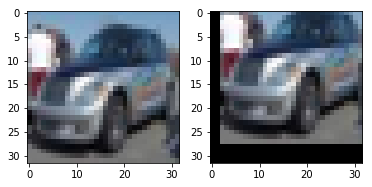

- RandomHorizontalFilp: Pour retourner l'image horizontalement.

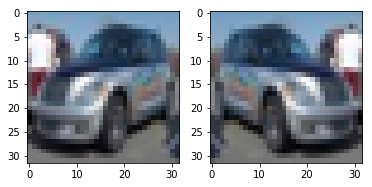

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


##Ajout de bruits 

Pourquoi ne pas utiliser le bruit comme un outil pour de la data augmentation ?

On obtient alors plus de données d’entraînement pour le modèle.
On entraîne le modèle sur des données bruitées ce qui permet une meilleure généralisation sur les données bruitées. généralisera bien sur des données bruyantes également.
Dans notre cas on va utiliser trois types de bruits:

gaussian noise:

salt and pepper noise:

speckle noise:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clean images :


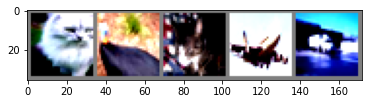

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gaussian noise :


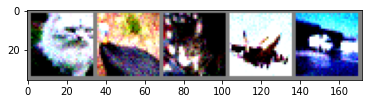

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Speckle noise :


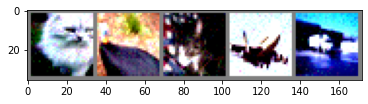

Salt&Pepper noise :


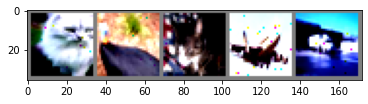

In [6]:
def add_gaussian_noise(images, seed=None):
    images = images.to(device)
    rng = np.random.default_rng(seed)
    noise = torch.tensor(rng.normal(0, 0.05 ** 0.5, images.shape), dtype=torch.float32).to(device)
    return   images + noise
    

def add_salt_pepper_noise(images):
    images = torch.tensor(random_noise(images, mode='s&p', amount = 0.005, salt_vs_pepper = 0., clip=True), dtype=torch.float32).to(device)
    return images

def add_speckle_noise(images, seed=None):
    images = images.to(device)
    rng = np.random.default_rng(seed)
    noise = torch.tensor(rng.normal(0, 0.05 ** 0.5, images.shape),  dtype=torch.float32).to(device)
    return images + images * noise


def add_noise(images):
    noises = ["gaussian", "speckle", "none"]
    noise = random.choice(noises)
    if(noise == "gaussian"):
        return add_gaussian_noise(images)
    elif(noise == "s&p"):
        return add_salt_pepper_noise(images)
    elif(noise == "s&p"):
        return add_speckle_noise(images)
    return images


num_img = 5
example_loader = torch.utils.data.DataLoader(trainset, batch_size=num_img, shuffle=True, num_workers=2)
dataiter = iter(example_loader)
images, labels = dataiter.next()

print("Clean images :")
imshow(torchvision.utils.make_grid(images))
print("Gaussian noise :")
images_gaussian = add_gaussian_noise(images)
imshow(torchvision.utils.make_grid(images_gaussian.cpu()))
print("Speckle noise :")
images_speckle = add_speckle_noise(images)
imshow(torchvision.utils.make_grid(images_speckle.cpu()))
print("Salt&Pepper noise :")
images_sp = add_salt_pepper_noise(images)
imshow(torchvision.utils.make_grid(images_sp.cpu()))



#Adversarial training

Nous avons vu avec les resultats précédents que notre modèle n'a pas su classifié les images attaqué avec le PGD. L'idée derrière l'adversarial training est d'attaquer les images d'entrainement et de s'entrainer sur ces dernières. Concrétement cela revient à rajouter une ligne dans notre fonction *training*:


```
images = attack.compute(images, labels)
```



In [ ]:
%%time
model = VGG('VGG16')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,  weight_decay=5e-4) #lr = 0.001 ne fait pas mieux
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

n_epochs = 220

attack = ProjectedGradientDescent(model,eps=0.03,alpha=0.007,num_iter=20)

print("Training with attack :")
training(model, criterion, optimizer, scheduler, n_epochs, attack)
save_model(model, "./vgg16_adv.pth")

Training with attack :
epoch 1 -> training_loss: 2.204
epoch 2 -> training_loss: 2.120
epoch 3 -> training_loss: 2.083
epoch 4 -> training_loss: 2.051
epoch 5 -> training_loss: 2.028
epoch 6 -> training_loss: 1.997
epoch 7 -> training_loss: 1.973
epoch 8 -> training_loss: 1.945
epoch 9 -> training_loss: 1.921
epoch 10 -> training_loss: 1.899
epoch 11 -> training_loss: 1.878
epoch 12 -> training_loss: 1.856
epoch 13 -> training_loss: 1.844
epoch 14 -> training_loss: 1.825
epoch 15 -> training_loss: 1.810
epoch 16 -> training_loss: 1.793
epoch 17 -> training_loss: 1.774
epoch 18 -> training_loss: 1.760
epoch 19 -> training_loss: 1.748
epoch 20 -> training_loss: 1.728
epoch 21 -> training_loss: 1.717
epoch 22 -> training_loss: 1.704
epoch 23 -> training_loss: 1.690
epoch 24 -> training_loss: 1.675
epoch 25 -> training_loss: 1.670
epoch 26 -> training_loss: 1.654
epoch 27 -> training_loss: 1.645
epoch 28 -> training_loss: 1.636
epoch 29 -> training_loss: 1.625
epoch 30 -> training_loss: 1.

#Evaluation du modèle après adversarial training

In [ ]:
#Eval Model Train With Adv Attack
model = VGG("VGG16")
load_model(model, './vgg16_adv.pth')
model = model.to(device)

print("Eval on clean images :")
eval_model(model, test_loader)

print("---- Num iter attack = 10 -----")
attack = ProjectedGradientDescent(model,eps=0.03,alpha=0.007,num_iter=10)
print("__________________________")
print("Eval on attacked images :")
eval_model(model, test_loader, attack)
print("__________________________")
print("Eval on attacked and noised images :")
eval_model(model, test_loader, attack, noise=True)

print("---- Num iter attack = 20 -----")
attack = ProjectedGradientDescent(model,eps=0.03,alpha=0.007,num_iter=20)
print("__________________________")
print("Eval on attacked images :")
eval_model(model, test_loader, attack)
print("__________________________")
print("Eval on attacked and noised images :")
eval_model(model, test_loader, attack, noise=True)

Eval on clean images :
Correct : 7238
Total : 10000
Accuracy: 72 %
---- Num iter attack = 10 -----
__________________________
Eval on noised images :
Correct : 5266
Total : 10000
Accuracy: 52 %
__________________________
Eval on attacked and noised images :
Correct : 5350
Total : 10000
Accuracy: 53 %
---- Num iter attack = 20 -----
__________________________
Eval on noised images :
Correct : 4106
Total : 10000
Accuracy: 41 %
__________________________
Eval on attacked and noised images :
Correct : 4181
Total : 10000
Accuracy: 41 %


On voit que le modèle à perdu un peu en accuracy sur les images non attaquées mais en contrepartie il est beaucoup plus robuste sur les images attaquées.

#Adversarial training + noise

On va maintenant entrainer un modèle en reprenant le principe d'adversarial training tout en rajoutant aléatoirement du bruit dans les images d'entrainement

In [ ]:
%%time
model = VGG('VGG16')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,  weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

n_epochs = 220

attack = ProjectedGradientDescent(model,eps=0.03,alpha=0.007,num_iter=20)

print("Training with attack :")
training(model, criterion, optimizer, scheduler, n_epochs, attack, noise=True)
save_model(model, "./vgg16_adv_noise.pth")

Training with attack :
epoch 1 -> training_loss: 2.196
epoch 2 -> training_loss: 2.114
epoch 3 -> training_loss: 2.076
epoch 4 -> training_loss: 2.048
epoch 5 -> training_loss: 2.026
epoch 6 -> training_loss: 2.003
epoch 7 -> training_loss: 1.971
epoch 8 -> training_loss: 1.945
epoch 9 -> training_loss: 1.925
epoch 10 -> training_loss: 1.903
epoch 11 -> training_loss: 1.885
epoch 12 -> training_loss: 1.867
epoch 13 -> training_loss: 1.852
epoch 14 -> training_loss: 1.834
epoch 15 -> training_loss: 1.819
epoch 16 -> training_loss: 1.801
epoch 17 -> training_loss: 1.785
epoch 18 -> training_loss: 1.772
epoch 19 -> training_loss: 1.762
epoch 20 -> training_loss: 1.744
epoch 21 -> training_loss: 1.737
epoch 22 -> training_loss: 1.720
epoch 23 -> training_loss: 1.707
epoch 24 -> training_loss: 1.692
epoch 25 -> training_loss: 1.683
epoch 26 -> training_loss: 1.670
epoch 27 -> training_loss: 1.666
epoch 28 -> training_loss: 1.649
epoch 29 -> training_loss: 1.641
epoch 30 -> training_loss: 1.

In [ ]:
#Eval Model Train With Adv Attack and noise
model = VGG("VGG16")
load_model(model, './vgg16_adv_noise.pth')
model = model.to(device)

print("Eval on clean images :")
eval_model(model, test_loader)

print("---- Num iter attack = 10 -----")
attack = ProjectedGradientDescent(model,eps=0.03,alpha=0.007,num_iter=10)
print("__________________________")
print("Eval on attacked images :")
eval_model(model, test_loader, attack)
print("__________________________")
print("Eval on attacked and noised images :")
eval_model(model, test_loader, attack, noise=True)

print("---- Num iter attack = 20 -----")
attack = ProjectedGradientDescent(model,eps=0.03,alpha=0.007,num_iter=20)
print("__________________________")
print("Eval on attacked images :")
eval_model(model, test_loader, attack)
print("__________________________")
print("Eval on attacked and noised images :")
eval_model(model, test_loader, attack, noise=True)

Eval on clean images :
Correct : 7258
Total : 10000
Accuracy: 72 %
---- Num iter attack = 10 -----
__________________________
Eval on attacked images :
Correct : 5195
Total : 10000
Accuracy: 51 %
__________________________
Eval on attacked and noised images :
Correct : 5318
Total : 10000
Accuracy: 53 %
---- Num iter attack = 20 -----
__________________________
Eval on attacked images :
Correct : 4030
Total : 10000
Accuracy: 40 %
__________________________
Eval on attacked and noised images :
Correct : 4112
Total : 10000
Accuracy: 41 %


On voit que les accuracy sont similaires au premier modèle entrainé avec l'adversarial training. Cela est peut être du au fait que nous n'avons pas assez mis de noise dans nos images.